# Particle Filter Experimental Results

This presents some of the results from the particle filter experiments. See [pf_experiments_plots.py](./pf_experiments_plots.py) for more results. This script mainly produces the graphs that are used in the accompanying paper.

## Initialisation

Read the requred libraries

In [1]:
%matplotlib inline

import os
import re
import math
import numpy as np
import matplotlib.pyplot as plt
#plt.ioff() # Turn off interactive mode
import pandas as pd
import sys
import warnings
from scipy.interpolate import griddata # For interpolating across irregularly spaced grid
import pickle # For saving computationally-expensive operations

# The following is to import the Particle Filter code
# (mostly we just read results that were created previously, but sometimes it's  useful to
# visualise additional experiments).
import sys
sys.path.append('../../stationsim')
sys.path.append('../..')
from stationsim.particle_filter import ParticleFilter
from stationsim.stationsim_model import Model
import time
import multiprocessing

Configure the script

In [2]:
# We need to tell the script which directory the results are in

# First try to get the directory of this .ipynb file
#root_dir = !echo %cd% # this might work under windows
root_dir = !pwd # under linux/mac # This works in linux/mac

# Now append the specific directory with results:
path = os.path.join(root_dir[0], "results","2/noise1")
print(f"Plotting results in directory: {path}")

# Need to set the number of particles and agents used in the experiments. These are set in the file that runs
# the experiments: ./run_pf.py
# Copy the lines near the top that set the number of particles and agents

# Lists of particles, agent numbers, and particle noise levels
num_par = list ( [1] + list(range(10, 50, 10)) + list(range(100, 501, 100)) + list(range(1000, 2001, 500)) + [3000, 5000, 7500, 10000])
num_age = [2, 5, 10, 15, 20, 30, 40, 50]

# Use log on y axis?
uselog = True

# Type of interpolation i.e. 'nearest' of 'linear' (see help(griddata)))
interpolate_method = "nearest"

Plotting results in directory: /Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/2/noise1


## Read the data

In [3]:
# From now on refer to the lists of agents and particles using different names (TODO: refactor)
particles = num_par
agents = num_age


if not os.path.isdir(path):
    sys.exit("Directory '{}' does not exist".format(path))


def is_duplicate(fname, files):
    """
    Sees if `fname` already exists in the `duplicates` list. Needs to strip off the integers at the end of
    the file (these were added by the Particle Filter script to prevent overridding experiments).
    :param fname:
    :param duplicates:
    :return: True if this file exists already, false otherwise
    """
    regex = re.compile(r"(.*?)-\d*\.csv") # Find everthing before the numbers at the end of the filename
    fname_stripped = re.findall(regex, fname)[0]
    for f in files:
        if re.findall(regex, f)[0] == fname_stripped:
            return True # There is a duplicate
    return False # No duplicates found


files = []
duplicates = [] # List of diplicate files
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.csv' in file:
            fname = os.path.join(r, file)
            if is_duplicate(fname, files):
                duplicates.append(fname)
            else:
                files.append(fname)

if len(files) == 0:
    sys.exit("Found no files in {}, can't continue".format(path) )
elif len(duplicates) > 0:
    warnings.warn("Found {} duplicate files:\n\t{}".format(len(duplicates), "\n\t".join(duplicates)))
else:
    print("Found {} files".format(len(files)))


# Errors are a matrix of particles * agents. These are a tuple because the errors
# are calculated before and after resampling

def init_matrix():
    return ( np.zeros(shape=(len(particles),len(agents))), np.zeros(shape=(len(particles),len(agents))) )

min_mean_err = init_matrix()
max_mean_err = init_matrix()
ave_mean_err = init_matrix() # Mean of the mean errors
med_mean_err = init_matrix() # Median of the mean errors
min_abs_err  = init_matrix()
max_abs_err  = init_matrix()
ave_abs_err  = init_matrix() # Mean of the mean errors
med_abs_err  = init_matrix() # Median of the mean errors
min_var      = init_matrix()
max_var      = init_matrix()
ave_var      = init_matrix()
med_var      = init_matrix()

# Regular expressions to find the particle number and population total from json-formatted info at the start of the file
particle_num_re = re.compile(r".*?'number_of_particles': (\d*).*?")
agent_num_re = re.compile(r".*?'pop_total': (\d*).*?")

print("Reading files....",)
data_shape = None # Check each file has a consistent shape
for i, f in enumerate(files):

    file = open(f,"r").read()
    #data = pd.read_csv(f, header = 2).replace('on',np.nan)
    data = pd.read_csv(f, header=2).replace('on', np.nan)
    # Check that each file has a consistent shape
    if i==0:
        data_shape=data.shape
    if data.shape != data_shape:
        # If the columns are the same and there are only a few (20%) rows missing then just continue
        if ( data_shape[1] == data.shape[1] ) and ( data.shape[0] > int(data_shape[0] - data_shape[0]*0.2) ):
            warnings.warn("Current file shape ({}) does not match the previous one ({}). Current file is: \n\t{}. \n\tLess than 20% rows missing so continuing".format(
                                  str(data.shape), str(data_shape), f ))
        # Can exit if the shapes are too bad (turn this off for now)
        #else:
        #    sys.exit("Current file shape ({}) does not match the previous one ({}). Current file is: \n\t{}. \n\tNot continuing".format(
        #            str(data.shape), str(data_shape), f  ))

    # Filter by whether errors are before or after (NOW DONE LATER, THIS CAN GO)
    #data = data[ data.loc[:,'Before_resample?'] == before]

    # Find the particle number and population total from json-formatted info at the start of the file
    search = re.findall(particle_num_re, file)
    try:
        particle_num = int(search[0])
    except:
        sys.exit("Error: could not find the number of particles in the header for file \n\t{}\n\tFound: '{}'".format(f, search))
    search = re.findall(agent_num_re, file)
    try:
        agent_num = int(search[0])
    except:
        sys.exit("Error: could not find the number of agents in the header for file \n\t{}\n\tFound: '{}'".format(f, search))
        
    # Calculate the statstics before and after resampling
    for before in [0,1]:
        d = data[ data.loc[:,'Before_resample?'] == before] # Filter data

        data_mean =  d.mean() # Calculate the mean of all columns
        data_median = d.median() # and also sometimes use median

        min_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Min_Mean_errors']
        max_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Max_Mean_errors']
        ave_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Average_mean_errors']
        med_mean_err[before][particles.index(particle_num),agents.index(agent_num)] = data_median['Average_mean_errors']
        min_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Min_Absolute_errors']
        max_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Max_Absolute_errors']
        ave_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Average_Absolute_errors']
        med_abs_err [before][particles.index(particle_num),agents.index(agent_num)] = data_median['Average_Absolute_errors']
        min_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Min_variances']
        max_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Max_variances']
        ave_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_mean['Average_variances']
        med_var     [before][particles.index(particle_num),agents.index(agent_num)] = data_median['Average_variances']
        
# There will never be zero error, so replace 0s with NA
data[data == 0] = np.nan        

print("...finished reading {} files".format(len(files)))

Found 124 files
Reading files....


/Users/nick/anaconda/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Current file shape ((18, 10)) does not match the previous one ((20, 10)). Current file is: 
	/Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/2/noise1/pf_particles_10000_agents_2_noise_1.0-1562357384.csv. 
	Less than 20% rows missing so continuing
/Users/nick/anaconda/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Current file shape ((56, 10)) does not match the previous one ((20, 10)). Current file is: 
	/Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/2/noise1/pf_particles_10000_agents_50_noise_1.0-1562249284.csv. 
	Less than 20% rows missing so continuing
/Users/nick/anaconda/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Current file shape ((40, 10)) does not match the previous one ((20, 10)). Current file is: 
	/Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/2

...finished reading 124 files


/Users/nick/anaconda/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Current file shape ((18, 10)) does not match the previous one ((20, 10)). Current file is: 
	/Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/2/noise1/pf_particles_7500_agents_20_noise_1.0-1562343040.csv. 
	Less than 20% rows missing so continuing
/Users/nick/anaconda/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Current file shape ((40, 10)) does not match the previous one ((20, 10)). Current file is: 
	/Users/nick/gp/dust/Projects/ABM_DA/experiments/pf_experiments/results/2/noise1/pf_particles_7500_agents_30_noise_1.0-1562249259.csv. 
	Less than 20% rows missing so continuing


Sanity check:

In [4]:
# Max error after resampling should be less than before resampling
print(f"Max errors (mean) (before/after): {max_mean_err[0].max()} / {max_mean_err[1].max()}")
assert max_mean_err[1].max() < max_mean_err[0].max() 
# Min error should not have gone up
print(f"Min errors (before/after): {min_mean_err[0].max()} / {min_mean_err[1].max()}")
assert min_mean_err[1].max() <= min_mean_err[0].max()
# Average errors should mostly have gone down (wont always happen due to addition of particle noise)
false_count = 0
total = 0
for b,a in zip(ave_mean_err[0], ave_mean_err[1]):
    total += len(b)
    for i in range(len(b)):
        if b[i] < a[i]:
            false_count += 1
print(f"In {false_count} / {total} experiments resampling *increased* the mean error")

Max errors (mean) (before/after): 105.05834173855209 / 59.19515462293167
Min errors (before/after): 5.3279555391723585 / 5.3279555391723585
In 17 / 136 experiments resampling *increased* the mean error


## Plot the results

### Sampling locations

Because the experiments are distributed across the agents/particles parameter space we need to create a grid and interpolate to show how the error varies

Text(0.5, 1.0, 'Sampling locations of experiments')

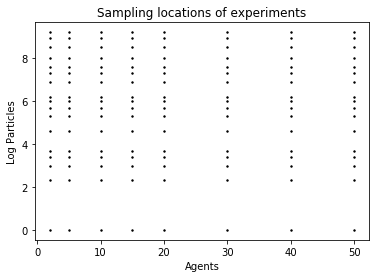

In [5]:
# First plot all of the locations in the grids for which we have data (these are
# not necessarily evenly spaced).
# See here for instructions on how to do heatmap with irregularly spaced data:
# https://scipy-cookbook.readthedocs.io/items/Matplotlib_Gridding_irregularly_spaced_data.html

# Define the grid.
# First need the points that the observations are taken at
x, y = [], []
for i in range(len(agents)):
    for j in range(len(particles)):
        x.append(agents[i])
        if uselog:
            y.append(np.log(particles[j]))
        else:
            y.append(particles[j])
x = np.array(x)
y = np.array(y)

# Now the grid to interpolate over (used later)
xi = np.linspace(0,max(agents)   ,100)
yi = None
if uselog:
    yi = np.geomspace(0.01,np.log(max(particles)),100)
else:
    yi = np.linspace(0,max(particles),100)

# Plot the point locations
plt.figure(0)
plt.scatter(x=x, y=y, marker='o',c='black',s=2)
plt.xlabel('Agents')
plt.ylabel('Log Particles' if uselog else 'Particles')
plt.title("Sampling locations of experiments")

Also need plot definitions so it is easy to extract the required data

In [6]:
# Define the plots so that they can be plotted in a loop
plot_def = {
    "Min absolute error" : min_mean_err,
    "Max absolute error" : max_mean_err,
    "Avg absolute error" : ave_mean_err,
    "Median mean error":  med_mean_err,
    "Min absolute error"  : min_abs_err,
    "Max absolute error"  : max_abs_err,
    "Avg absolute error"  : ave_abs_err,
    "Median absolute error": med_abs_err,
    "Min variance"   : min_var,
    "Max variance"   : max_var,
    "Avg variance"  : ave_var,
    "Median variance"  : med_var
    }

And some functions / other parameters that are consistent across all plots:

In [7]:
# Some things that are consistent across all the plots
_xlabel = 'Number of Agents'
_ylabel = lambda x: 'Log(n) Number of Particles' if x else 'Number of Particles'

# Font sizes (from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 13
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the figure title (when using axes)

def make_z(d):
    """Calculate the value of the statistic being visualised (e.g. mean_error) as a long list"""
    z = []
    for i in range(len(agents)):
        for j in range(len(particles)):
            z.append(d[j,i])
    assert len(x) == len(y) and len(x) == len(z)
    return np.array(z)

def make_zi(z):
    """Grid the data"""
    return griddata(points=(x, y),
              values=z,
              xi=(xi[None,:], yi[:,None]),
              method=interpolate_method)

### Headline Plot: Median error after resampling


The headline: how the error changes with number of particles v.s. number of agents.

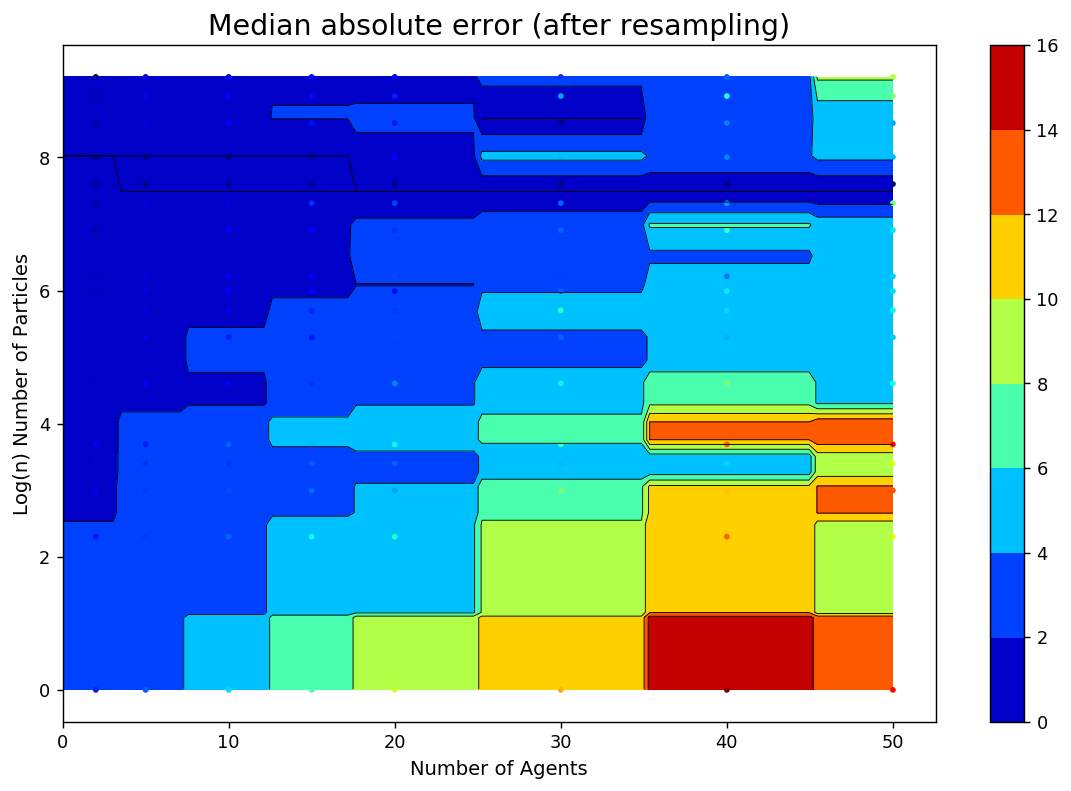

In [8]:
# Title and array
title = "Median absolute error"
d = plot_def[title][1] # Index 1 for the array created *after* resampling

# Calculate the value of the error statistic as a long list
z = make_z(d)

# Turn that into a grid
zi = make_zi(z)

fig = plt.figure(num=None, figsize=(11, 7), dpi=128, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
cs1 = plt.contour( xi,yi,zi,8,linewidths=0.5,colors='k')
cs2 = plt.contourf(xi,yi,zi,8,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
#plt.scatter(x,y,marker='o',c=[cs2.get_cmap()(val) for val in z], s=2)
plt.scatter(x,y,marker='o',c=z, cmap=cs2.get_cmap(), s=5)
plt.xlabel(_xlabel)
plt.ylabel(_ylabel(uselog))
# Make the numbers not logged
#locs, labels = plt.yticks() # So that numbers are not logged 
#plt.yticks(locs, [math.exp(int(x.get_text())) if int(x.get_text().replace("'",'')) > 0 else '' for x in labels]) 
plt.title(title+" (after resampling)", fontsize=16)
#plt.show()
plt.savefig("figs_for_pf_paper/median_abs_error.pdf", bbox_inches="tight")
del(z, d, zi) # tidy up

### Visualising Individual PF instances

What does that error actually mean in practice? Take a snaphsot of a high- and low- error PF implementation while it's running to give an idea about how close it gets to the 'real' system

In [9]:
# These are the basic parameter settings required. 
# We will chance the number of particles and agents to see what the experiments are like

model_params = {
    'width': 200,
    'height': 100,
    'pop_total': 10, # IMPORTANT: number of agents
    'speed_min': .1,
    'separation': 2,
    'batch_iterations': 4000,  # Only relevant in batch() mode
    'do_history': False,
    'do_print': False,
}
# Model(model_params).batch() # Runs the model as normal (one run)

filter_params = {
    'number_of_particles': 10, #IMPORTANT: number of particles
    'number_of_runs': 1,  # Number of times to run each particle filter configuration
    'resample_window': 100,
    'multi_step': True,  # Whether to predict() repeatedly until the sampling window is reached
    'particle_std': 1.0, # Noise added to particles
    'model_std': 1.0, # Observation noise
    'agents_to_visualise': 10,
    'do_save': True,
    'plot_save': False,
    'do_ani': True, # Do the animation (generatea plot at each data assimilation window)
    'show_ani': False, # Don't actually show the animation. They can be extracted later from self.animation
}

#### 10 agents, 10 particles, First two windows

This shows that with only a few agents there is very little stochasticity, so even with only 10 particles the system is easy to estimate.

In [10]:
# Temporarily turn off plotting (the 'show_ani' should stop plots being displayed,
# but doesn't work for some reason)
%matplotlib auto

model_params['pop_total'] = 10
filter_params['number_of_particles'] = 10
pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
result = pf.step() # Run the particle filter

# For some reason the pool doesn't always kill it's child processes (notebook problem?)
pf.pool.close() 

# Turn on inline plotting again
%matplotlib inline

Using matplotlib backend: MacOSX
Running filter with 10 particles and 1 runs (on 16 cores) with 10 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 0.74s)
	Finished window 2, step 200 (took 0.34s)
	Finished window 3, step 300 (took 0.08s)


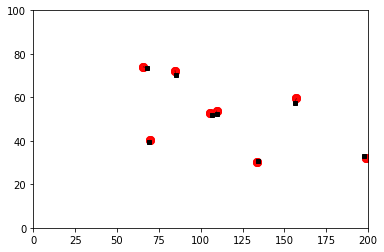

In [11]:
pf.animation[0]

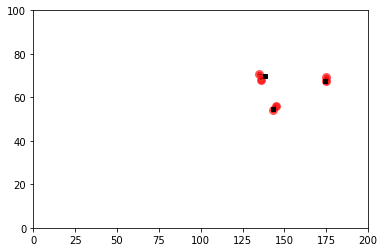

In [12]:
pf.animation[1]

If we want to re-save the images (don't necessarily want to do this if I was happy with the preivous ones they vary slightly each time the model runs.

In [14]:
#pf.animation[0].savefig("figs_for_pf_paper/ani-10agents-10particles-window100.pdf", bbox_inches="tight")
#pf.animation[1].savefig("figs_for_pf_paper/ani-10agents-10particles-window200.pdf", bbox_inches="tight")

#### 50 agents, 10 particles, First three windows

With 50 agents and still only 10 particles we start to see some agents being very poorly simulated. There are examples of XXXX (no particles correctly simulating an agent)

In [37]:
# Temporarily turn off plotting (the 'show_ani' should stop plots being displayed,
# but doesn't work for some reason)
%matplotlib auto

N = 50
NP = 10
model_params['pop_total'] = N
filter_params['number_of_particles'] = NP
filter_params['agents_to_visualise'] = N
pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
result = pf.step() # Run the particle filter

# For some reason the pool doesn't always kill it's child processes (notebook problem?)
pf.pool.close() 

# Turn on inline plotting again
%matplotlib inline

Using matplotlib backend: MacOSX
Running filter with 10 particles and 1 runs (on 16 cores) with 50 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 3.67s)
	Finished window 2, step 200 (took 2.69s)
	Finished window 3, step 300 (took 1.43s)
	Finished window 4, step 400 (took 0.74s)
	Finished window 5, step 500 (took 0.11s)


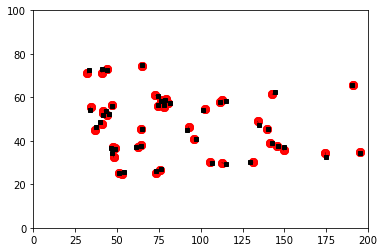

In [38]:
pf.animation[0]

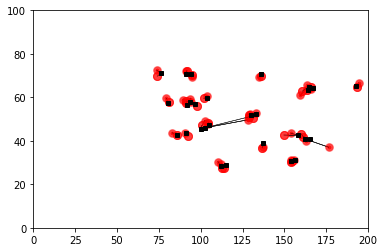

In [39]:
pf.animation[1]

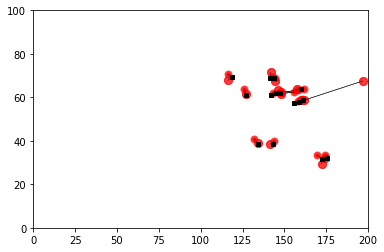

In [40]:
pf.animation[2]

If we want to re-save the images the uncomment below (don't necessarily want to do this if I was happy with the preivous ones they vary slightly each time the model runs).

In [41]:
#pf.animation[0].savefig(f"figs_for_pf_paper/ani-{N}agents-{NP}particles-window100.pdf", bbox_inches="tight")
#pf.animation[1].savefig(f"figs_for_pf_paper/ani-{N}agents-{NP}particles-window200.pdf", bbox_inches="tight")
#pf.animation[2].savefig(f"figs_for_pf_paper/ani-{N}agents-{NP}particles-window300.pdf", bbox_inches="tight")

#### 50 agents, 5000 particles, First three windows

Now with many more particles ..... XXXX HERE

In [ ]:
# Temporarily turn off plotting (the 'show_ani' should stop plots being displayed,
# but doesn't work for some reason)
%matplotlib auto

N = 50
NP = 5000

# Try to load the complete particle filter results from a pickled file. If none are available then re-run the PF
pf = None
pickle_file = f"./pickles/{N}agents_{NP}particles.pickle"

try:
    with open(pickle_file, 'rb') as f:
        pf = pickle.load(f)
        print(f"Loaded previous PF run from file {pickle_file}")
except FileNotFoundError as e:
    print("Could not load previously-run PF from file. Re-running code (go and make a cup of tea)")
    pf = None # (not sure this is necessary)
    
if pf == None:
    
    model_params['pop_total'] = N
    filter_params['number_of_particles'] = NP
    filter_params['agents_to_visualise'] = N
    pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()/2))
    result = pf.step() # Run the particle filter

    # For some reason the pool doesn't always kill it's child processes (notebook problem?)
    pf.pool.close()
    
    pf.pool = None # This is necessary to allow pickling
    
    # Save the particle filter object as a pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(pf, f)

# Turn on inline plotting again
%matplotlib inline

Using matplotlib backend: MacOSX
Could not load previously-run PF from file. Re-running code (go and make a cup of tea)
Running filter with 5000 particles and 1 runs (on 8 cores) with 50 agents.
Starting particle filter step()


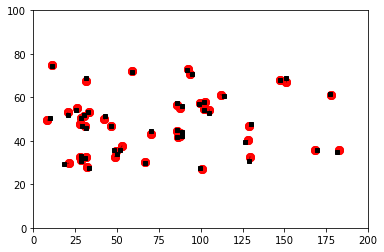

In [45]:
pf.animation[0]

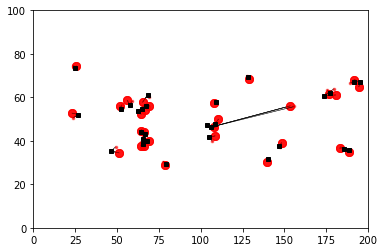

In [46]:
pf.animation[1]

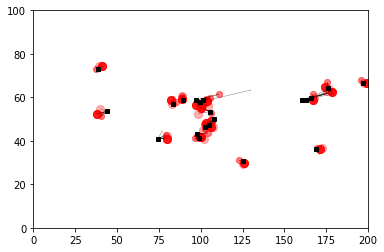

In [47]:
pf.animation[2]

In [23]:
pf.animation[0].savefig(f"figs_for_pf_paper/ani-{N}agents-{NP}particles-window100.pdf", bbox_inches="tight")
pf.animation[1].savefig(f"figs_for_pf_paper/ani-{N}agents-{NP}particles-window200.pdf", bbox_inches="tight")
pf.animation[2].savefig(f"figs_for_pf_paper/ani-{N}agents-{NP}particles-window300.pdf", bbox_inches="tight")

### Impact of Resampling

Plots that show how resampling reduced the error of the population of particles

In [ ]:
# Title and array
title = "Median absolute error"
d0 = plot_def[title][0] # Index 1 for the array created *beforer* resampling
d1 = plot_def[title][1] # Index 1 for the array created *after* resampling

# Calculate the value of the error statistic as a long list
z0 = make_z(d0)
z1 = make_z(d1)

# Turn that into a grid
zi0 = make_zi(z0)
zi1 = make_zi(z1)

fig = plt.figure(num=None, figsize=(11, 5), dpi=128, facecolor='w', edgecolor='k')

ax0 = plt.subplot(121) #nrows, ncols, index,
cs1 = plt.contour( xi,yi,zi0,8,linewidths=0.5,colors='k')
cs2 = plt.contourf(xi,yi,zi0,8,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
plt.scatter(x,y,marker='o',c=z0, cmap=cs2.get_cmap(), s=5)
plt.xlabel(_xlabel)
plt.ylabel(_ylabel(uselog))
plt.title(f"{title}\nbefore resampling)")

ax1 = plt.subplot(122) #nrows, ncols, index,
cs1 = plt.contour( xi,yi,zi1,8,linewidths=0.5,colors='k')
cs2 = plt.contourf(xi,yi,zi1,8,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
plt.scatter(x,y,marker='o',c=z1, cmap=cs2.get_cmap(), s=5)
plt.xlabel(_xlabel)
#plt.ylabel(_ylabel(uselog))
plt.title(f"{title}\nafter resampling")

#plt.show()
plt.savefig("figs_for_pf_paper/resampling.pdf", bbox_inches="tight")


### Impact of Noise

Plots that show the impact of changing the amount of particle noise from $\sigma_p=1$ to $\sigma_p=2$

In [ ]:
XXXX

plt.figure(1)
plt.subplot(211) #nrows, ncols, index,
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

plt.subplot(212) #nrows, ncols, index,
plt.plot(t2, np.cos(2*np.pi*t2), 'r--')
plt.show()



### All plots

Do all plots at once

In [ ]:
for before in [0,1]:
    for i, (title, d) in enumerate(plot_def.items()): # d is the data to plot (an np array)
        
        d = d[before] # d is a tuple (data before and data after)
        
        # The value of the statistic being visualised (e.g. mean_error) as a long list
        z = []
        for i in range(len(agents)):
            for j in range(len(particles)):
                z.append(d[j,i])
        assert len(x) == len(y) and len(x) == len(z)
        z = np.array(z)
        # Grid the data
        zi = griddata(points=(x, y),
                      values=z,
                      xi=(xi[None,:], yi[:,None]),
                      method=interpolate_method)
    
        plt.figure(i+1) # (+1 because there was a figure before)
        cs1 = plt.contour( xi,yi,zi,8,linewidths=0.5,colors='k')
        cs2 = plt.contourf(xi,yi,zi,8,cmap=plt.cm.jet)
        plt.colorbar() # draw colorbar
        #plt.scatter(x,y,marker='o',c=[cs2.get_cmap()(val) for val in z], s=2)
        plt.scatter(x,y,marker='o',c=z, cmap=cs2.get_cmap(), s=5)
        plt.xlabel('Agents')
        plt.ylabel('Log Particles' if uselog else 'Particles')
        plt.title(title+" ({} resampling)".format('before' if before==0 else 'after') )
        plt.show()

print("Finished.")